In [108]:
from IPython.display import Image
from IPython.core.display import HTML 
import pandas as pd
import geopandas as gpd
import numpy as np
import ipywidgets
import matplotlib.pyplot as plt
import osmnx as ox
import networkx as nx
import re

# The Effect of Traffic Events on NYC Taxi Trips
## Tali Zacks and Raghid Alhazmy
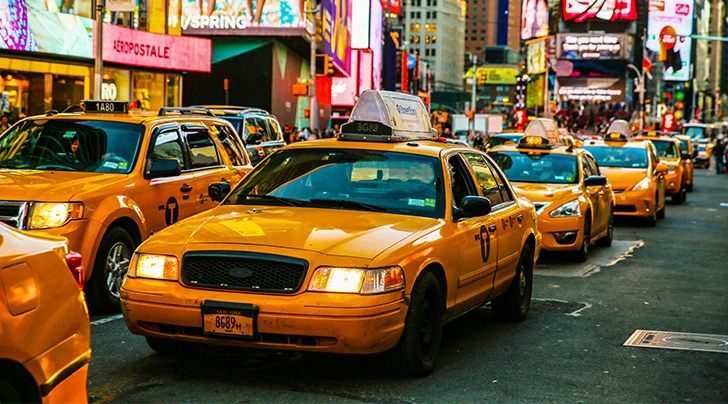

# Planning
- Our project began as a vague city simulation that would calculate the likelihood of meeting another person given certain criteria (e.g. age, height, occupation, primary travel method, gender, sexuality, religion, etc.)
- For this to become a reality (which it didn't), we would need extensive census data that likely doesn't exist AND we would need to essentially simulate the goings-on a full city
- In the preliminary planning stage, without a solid idea, we began searching for city data that was publically available and started asking ourselves questions that we might be able to answer with analysis of the data or with a simulation
- This led us to NYC Open Data (https://data.cityofnewyork.us) which contains thousands of open source datasets published by officials within the city of New York
![](https://www.nyc.gov/assets/operations/images/content/researchandanalytics/programs_OpenData.png)

# Finding the Right Data to Formulate a Project Idea
- With the thousands of open source datasets about NYC available to us, we began scouring the site to see if anything fit
- Eventually we came across Yellow Taxi data
    - This includes 112,234,626 taxi trips
    - VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance, RatecodeID, store_and_fwd_flag, PULocationID, DOLocationID, payment_type, fare_amount, extra, mta_tax, tip_amount, tolls_amount, improvement_surcharge,total_amount
    
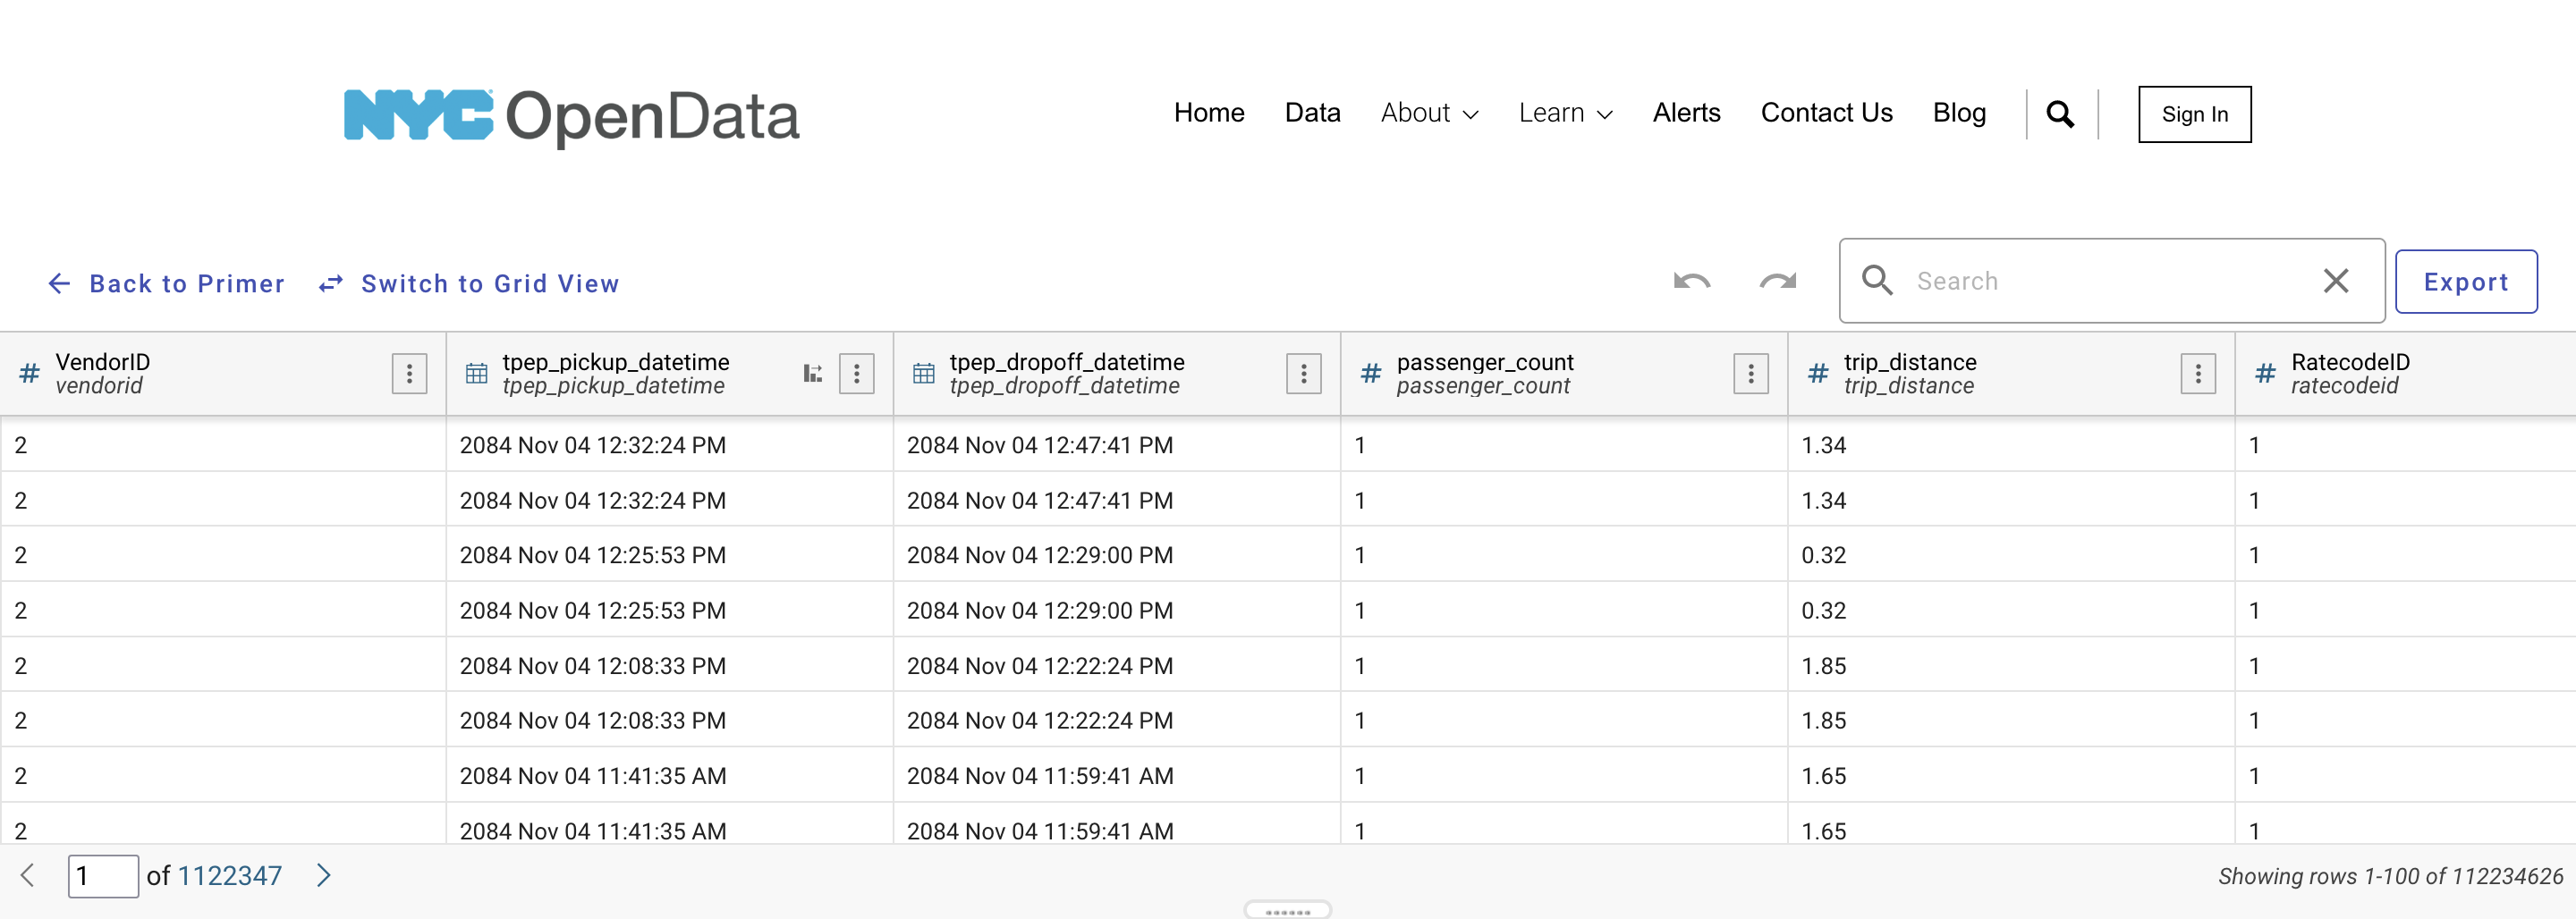

- Our first idea was to compare prices and frequency of Yellow Taxi trips to Uber/Lyft trips
- The first snag was that the data available for Uber/Lyft trips didn't actually include a lot of the data that would have been required to compare the two methods of transportation

# Finding the Right Data to Formulate a Project Idea
- We then found NYC motor vehicle crash data
    - 1,987,996 crashes
    -'CRASH DATE_CRASH TIME', 'BOROUGH', 'ZIP CODE',
       'LATITUDE', 'LONGITUDE', 'LOCATION', 'ON STREET NAME',
       'CROSS STREET NAME', 'OFF STREET NAME', 'NUMBER OF PERSONS INJURED',
       'NUMBER OF PERSONS KILLED', 'NUMBER OF PEDESTRIANS INJURED',
       'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED',
       'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED',
       'NUMBER OF MOTORIST KILLED', 'CONTRIBUTING FACTOR VEHICLE 1',
       'CONTRIBUTING FACTOR VEHICLE 2', 'CONTRIBUTING FACTOR VEHICLE 3',
       'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5',
       'COLLISION_ID', 'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2',
       'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5'

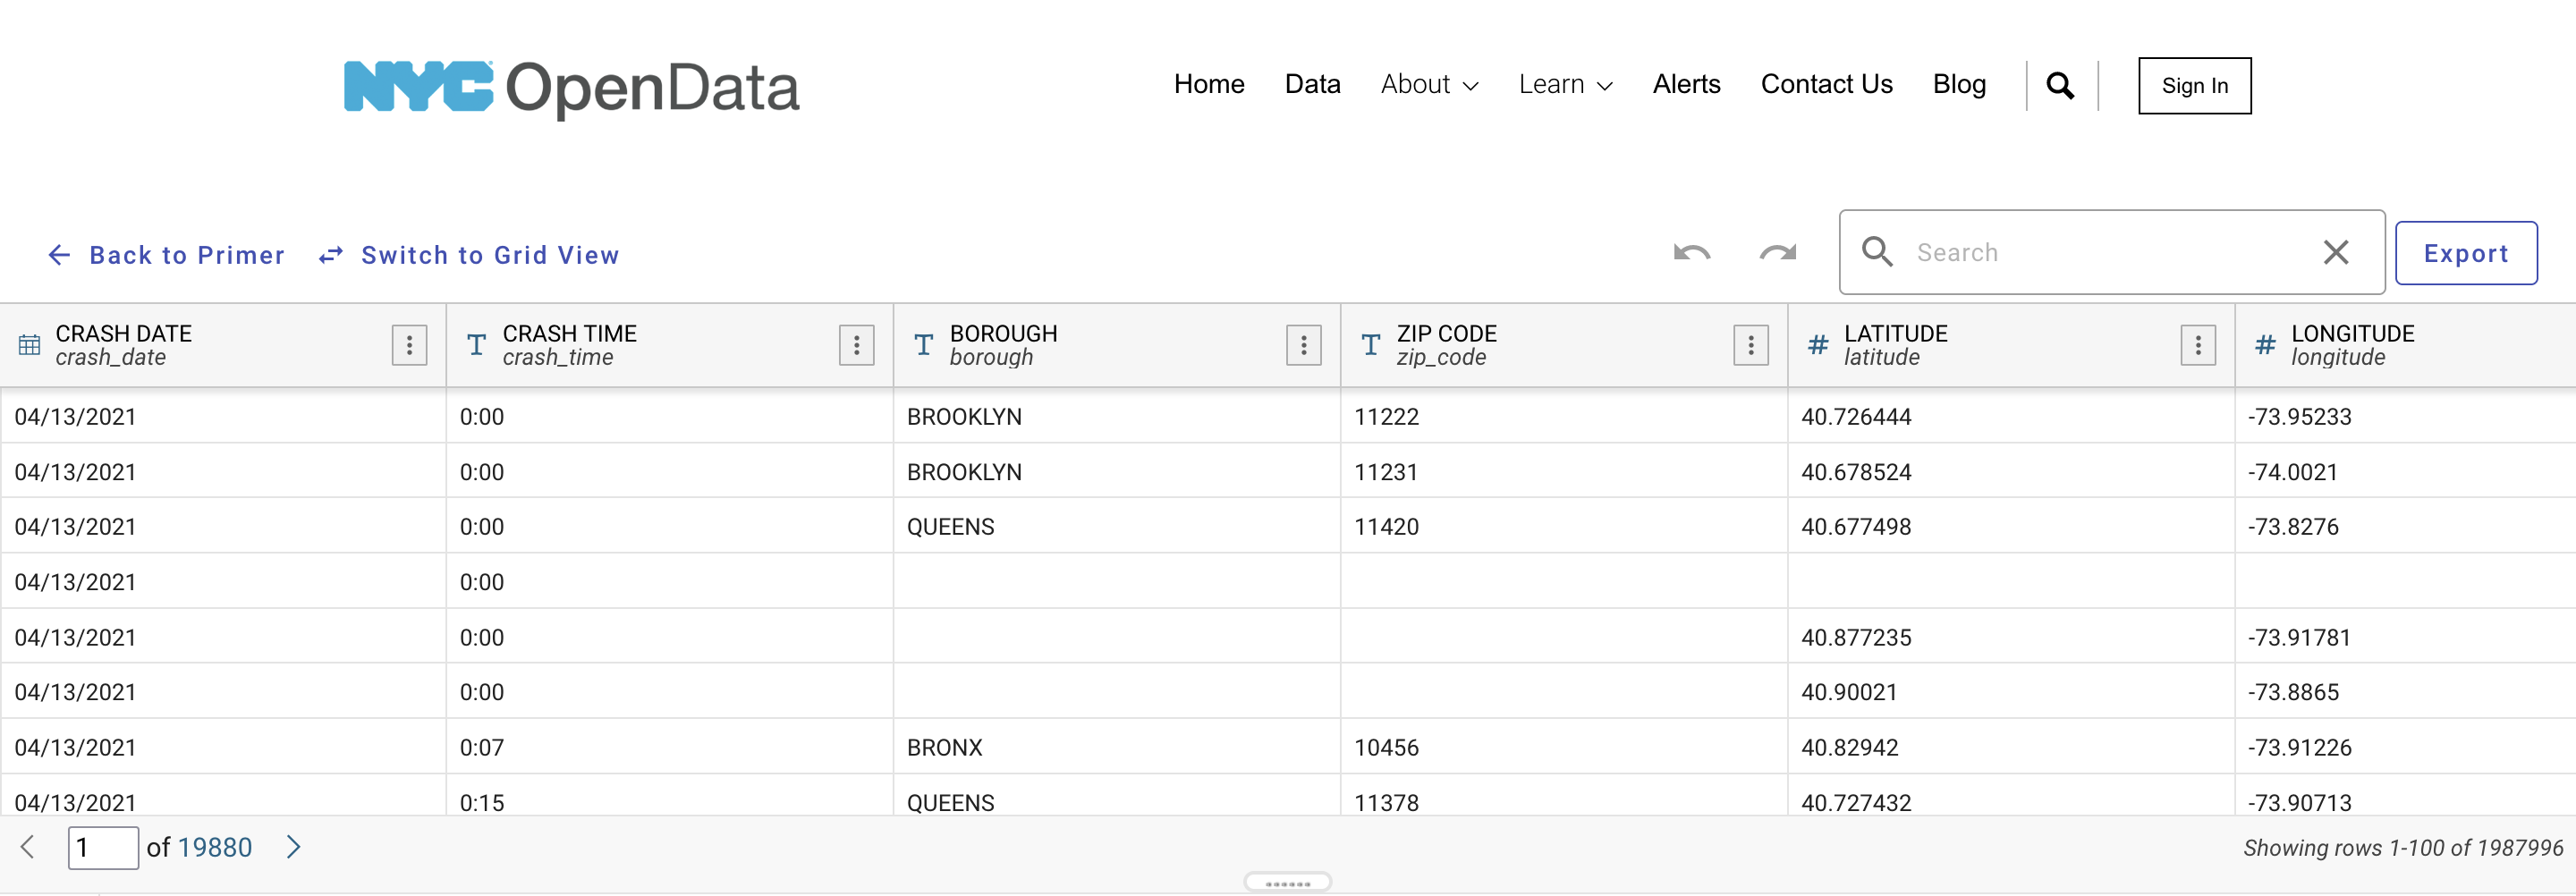


- We then discovered NYC Street Closure data
    - 107,475 Closures
    - SEGMENTID, ONSTREETNAME, FROMSTREETNAME, TOSTREETNAME, BOROUGH_CODE, WORK_START_DATE, WORK_END_DATE, PURPOSE

## Hypotheses:
1. Crashes and closures in nearby zones will cause increases in trip time
2. Crashes in a single zone will cause be followed by more crashes in the same zone (crashes tend to cluster)

# The Data
- A file with 112 million Taxi trips was FAR too large to download successfully onto our machines
- However, we were able to download them (painstakingly) month by month 
- For this reason we also decided to restrict our analysis to a single year: 2018
    - We also filtered our other datasets to include only data recorded in 2018
- And then we sampled 50,000 trips from each month and concatenated them into one DataFrame and saved it as a csv

In [37]:
def combine_taxi_dfs() -> pd.DataFrame:
    dfs = []
    for i in range(1,13):
        df = pd.read_csv(f'taxi/Yellow_Taxi_Trip_Data_{i}_2018.csv', infer_datetime_format=True, parse_date)
        dfs.append(df.sample(50000))
    return dfs

combined = pd.concat(combine_taxi_dfs()).sort_values(by='tpep_pickup_datetime')

In [84]:
combined = pd.read_csv('sampled_combined_taxi_2018_600k.csv',parse_dates = ['tpep_pickup_datetime','tpep_dropoff_datetime'])


In [90]:
combined.rename(columns = {'Unnamed: 0':'tripID'},inplace = True)
combined

tripID  VendorID tpep_pickup_datetime tpep_dropoff_datetime  \
0       19061628         2  2018-01-01 01:00:03   2018-01-01 01:11:10   
1       19061445         1  2018-01-01 01:00:38   2018-01-01 01:08:50   
2        9350400         2  2018-01-01 01:00:53   2018-01-01 01:22:33   
3        9350381         2  2018-01-01 01:00:56   2018-01-01 01:15:04   
4       19061290         2  2018-01-01 01:01:05   2018-01-01 01:03:40   
...          ...       ...                  ...                   ...   
599995    202215         2  2018-12-31 00:58:13   2018-12-31 01:23:11   
599996    142307         2  2018-12-31 12:58:18   2018-12-31 13:13:30   
599997    142263         2  2018-12-31 12:58:37   2018-12-31 13:30:14   
599998    142237         2  2018-12-31 12:58:46   2018-12-31 13:01:16   
599999    142233         2  2018-12-31 12:58:47   2018-12-31 13:06:13   

        passenger_count  trip_distance  RatecodeID store_and_fwd_flag  \
0                     1           2.56           1                  N   
1                     4           0.80           1                  N   
2                     5           2.67           1                  N   
3                     1           2.21           1                  N   
4                     1           0.44           1                  N   
...                 ...            ...         ...                ...   
599995                2           6.15           1                  N   
599996                1           5.20           1                  N   
599997                6          18.45           2                  N   
599998                1           0.34           1                  N   
599999                2           1.29           1                  N   

        PULocationID  DOLocationID  payment_type  fare_amount  extra  mta_tax  \
0                166           239             2         10.5    0.5      0.5   
1                 79           148             2          7.0    0.5      0.5   
2                234           148             2         14.5    0.5      0.5   
3                 68           234             2         11.0    0.5      0.5   
4                238           239             1          4.0    0.5      0.5   
...              ...           ...           ...          ...    ...      ...   
599995           237           173             2         22.5    0.5      0.5   
599996           170           209             1         18.0    0.0      0.5   
599997           132            90             2         52.0    0.0      0.5   
599998           142           142             1          3.5    0.0      0.5   
599999           170           229             1          7.0    0.0      0.5   

        tip_amount  tolls_amount  improvement_surcharge  total_amount  tripID  
0             0.00          0.00                    0.3         11.80       0  
1             0.00          0.00                    0.3          8.30       1  
2             0.00          0.00                    0.3         15.80       2  
3             0.00          0.00                    0.3         12.30       3  
4             1.06          0.00                    0.3          6.36       4  
...            ...           ...                    ...           ...     ...  
599995        0.00          0.00                    0.3         23.80  599995  
599996        3.76          0.00                    0.3         22.56  599996  
599997        0.00          5.76                    0.3         58.56  599997  
599998        0.86          0.00                    0.3          5.16  599998  
599999        1.56          0.00                    0.3          9.36  599999  

[600000 rows x 19 columns]

# Beginning to Deal with the Data
- It was at this point, we realized that the taxi trips included only a pickup and drop off "zone" and not actual coordinates
- We went back to NYC Open Data and found a GeoJSON file which included the geometries of each zone

In [9]:
nyc_gdf = gpd.read_file('NYC_Taxi_Zones.geojson')
nyc_gdf.set_index('objectid')
nyc_gdf

shape_area objectid       shape_leng location_id  \
0       0.0007823067885        1   0.116357453189           1   
1      0.00486634037837        2    0.43346966679           2   
2     0.000314414156821        3  0.0843411059012           3   
3     0.000111871946192        4  0.0435665270921           4   
4     0.000497957489363        5  0.0921464898574           5   
..                  ...      ...              ...         ...   
258   0.000168611097013      256  0.0679149669603         256   
259   0.000394552487366      259   0.126750305191         259   
260   0.000422345326907      260   0.133514154636         260   
261  0.0000343423231652      261  0.0271204563616         261   
262   0.000122330270966      262  0.0490636231541         262   

                          zone        borough  \
0               Newark Airport            EWR   
1                  Jamaica Bay         Queens   
2      Allerton/Pelham Gardens          Bronx   
3                Alphabet City      Manhattan   
4                Arden Heights  Staten Island   
..                         ...            ...   
258  Williamsburg (South Side)       Brooklyn   
259         Woodlawn/Wakefield          Bronx   
260                   Woodside         Queens   
261         World Trade Center      Manhattan   
262             Yorkville East      Manhattan   

                                              geometry  
0    MULTIPOLYGON (((-74.18445 40.69500, -74.18449 ...  
1    MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ...  
2    MULTIPOLYGON (((-73.84793 40.87134, -73.84725 ...  
3    MULTIPOLYGON (((-73.97177 40.72582, -73.97179 ...  
4    MULTIPOLYGON (((-74.17422 40.56257, -74.17349 ...  
..                                                 ...  
258  MULTIPOLYGON (((-73.95834 40.71331, -73.95681 ...  
259  MULTIPOLYGON (((-73.85107 40.91037, -73.85207 ...  
260  MULTIPOLYGON (((-73.90175 40.76078, -73.90147 ...  
261  MULTIPOLYGON (((-74.01333 40.70503, -74.01327 ...  
262  MULTIPOLYGON (((-73.94383 40.78286, -73.94376 ...  

[263 rows x 7 columns]

In [10]:
nyc_gdf.explore()

# Trips Between Zones?
- We concluded that traveling between more than a few zones would make analysis more difficult and we still had 600,000 trips so we could afford to filter out those which began and ended outside of a certain range
- Our cutoff was to only include trips between neighboring zones and neighbors of neighboring zones
- GeoPandas allows you to assess the geometries which do not share any sides with other geometries using the disjoint method

In [14]:
neighbor_dict = {}
for index, zone in nyc_gdf.iterrows(): # pls don't be mad
    # get 'not disjoint' zones
    neighbors = nyc_gdf[~nyc_gdf.geometry.disjoint(zone.geometry)].objectid.tolist()

    # remove own zone number from the list
    neighbors = [int(num) for num in neighbors if zone.objectid != num]

    #add zone neighbors to neighbor dictionary
    neighbor_dict[index + 1] = neighbors
neighbor_dict

{1: [],
 2: [30, 132],
 3: [32, 51, 81, 184, 185, 242, 254],
 4: [79, 148, 224, 232],
 5: [84, 99, 204],
 6: [115, 118, 214, 221],
 7: [146, 179, 193, 207, 226, 223, 260],
 8: [179, 223],
 9: [16, 73, 98, 121, 171, 192],
 10: [41, 43, 151, 166],
 11: [205, 215, 216, 218, 219],
 12: [14, 22, 67],
 13: [13, 88, 261],
 14: [12, 231, 261],
 15: [20, 94, 136, 174, 241],
 16: [33, 40, 52, 65, 97, 106, 181],
 17: [11, 67, 227, 228],
 18: [16, 171, 252],
 19: [11, 21, 26, 67],
 20: [99, 118, 156, 187, 251],
 21: [9, 15, 64, 98, 171, 175],
 22: [37, 49, 61, 80, 217, 225],
 23: [64, 101, 175, 191],
 24: [18, 31, 47, 78, 94, 174],
 25: [22, 26, 108, 123, 178],
 26: [22, 21, 67, 89, 111, 133, 178, 227],
 27: [201],
 28: [93, 121, 134, 130, 131, 135, 197],
 29: [25, 52, 54, 65, 66],
 30: [55, 108, 150, 123, 210],
 31: [20, 32, 78, 174, 185, 240, 242, 254],
 32: [3, 31, 185, 254],
 33: [2],
 34: [49, 66, 97, 217, 256],
 35: [61, 72, 76, 77, 177],
 36: [37, 80, 96, 198],
 37: [17, 36, 63, 80, 96, 177

# Filtering
- We then filtered out the trips that started from or ended in zones which didn't have neighbors or were from zones that didn't actually exist (Zones 264 and 265)

In [91]:
trips_zones_dict = {}
df = combined
# keep only trips that have PO and DO zones that aren't above 263
limit_mask = (df['PULocationID'] < 264) & (df['DOLocationID'] < 264)

# Find zones with no neighbors
dont_include = []
for x in neighbor_dict:
    if neighbor_dict[x] == []:
        dont_include.append(x)

# apply masks
trips_df = df[limit_mask]

# create mask to remove trips that start or end in a zone without neighbors
no_neighbors_mask = (~trips_df['PULocationID'].isin(dont_include)) & (~trips_df['DOLocationID'].isin(dont_include))

trips_df = trips_df[no_neighbors_mask]

- Next, we found and excluded the trips that didn't end either in one of the PU zones's neighbors or one of the neighbor's neighbors
- Then to analyze the trip times and speeds, we created new columns for each trip

In [92]:
column_names = ['tpep_pickup_datetime', 'tpep_dropoff_datetime']
for column in column_names:
    trips_df[column] = pd.to_datetime(trips_df[column],'%m/%d/%Y %I:%M:%S %p')
def add_time_and_speed(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculates the trip time and average speed of a taxi trip and creates two columns in the taxi dataframe
     to store the data
    :param df: taxi pandas dataframe
    :return: The taxi dataframe with trip_time_h and avg speed columns
    """
    df['trip_time'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime'])

    df['trip_time_h'] = [(x.total_seconds()) / 3600 for x in df['trip_time']]
    df['avg speed'] = df['trip_distance'] / df['trip_time_h']
    return df
add_time_and_speed(trips_df)

tripID  VendorID tpep_pickup_datetime tpep_dropoff_datetime  \
0       19061628         2  2018-01-01 01:00:03   2018-01-01 01:11:10   
1       19061445         1  2018-01-01 01:00:38   2018-01-01 01:08:50   
2        9350400         2  2018-01-01 01:00:53   2018-01-01 01:22:33   
3        9350381         2  2018-01-01 01:00:56   2018-01-01 01:15:04   
4       19061290         2  2018-01-01 01:01:05   2018-01-01 01:03:40   
...          ...       ...                  ...                   ...   
599995    202215         2  2018-12-31 00:58:13   2018-12-31 01:23:11   
599996    142307         2  2018-12-31 12:58:18   2018-12-31 13:13:30   
599997    142263         2  2018-12-31 12:58:37   2018-12-31 13:30:14   
599998    142237         2  2018-12-31 12:58:46   2018-12-31 13:01:16   
599999    142233         2  2018-12-31 12:58:47   2018-12-31 13:06:13   

        passenger_count  trip_distance  RatecodeID store_and_fwd_flag  \
0                     1           2.56           1                  N   
1                     4           0.80           1                  N   
2                     5           2.67           1                  N   
3                     1           2.21           1                  N   
4                     1           0.44           1                  N   
...                 ...            ...         ...                ...   
599995                2           6.15           1                  N   
599996                1           5.20           1                  N   
599997                6          18.45           2                  N   
599998                1           0.34           1                  N   
599999                2           1.29           1                  N   

        PULocationID  DOLocationID  ...  extra  mta_tax  tip_amount  \
0                166           239  ...    0.5      0.5        0.00   
1                 79           148  ...    0.5      0.5        0.00   
2                234           148  ...    0.5      0.5        0.00   
3                 68           234  ...    0.5      0.5        0.00   
4                238           239  ...    0.5      0.5        1.06   
...              ...           ...  ...    ...      ...         ...   
599995           237           173  ...    0.5      0.5        0.00   
599996           170           209  ...    0.0      0.5        3.76   
599997           132            90  ...    0.0      0.5        0.00   
599998           142           142  ...    0.0      0.5        0.86   
599999           170           229  ...    0.0      0.5        1.56   

        tolls_amount  improvement_surcharge  total_amount  tripID  \
0               0.00                    0.3         11.80       0   
1               0.00                    0.3          8.30       1   
2               0.00                    0.3         15.80       2   
3               0.00                    0.3         12.30       3   
4               0.00                    0.3          6.36       4   
...              ...                    ...           ...     ...   
599995          0.00                    0.3         23.80  599995   
599996          0.00                    0.3         22.56  599996   
599997          5.76                    0.3         58.56  599997   
599998          0.00                    0.3          5.16  599998   
599999          0.00                    0.3          9.36  599999   

             trip_time  trip_time_h  avg speed  
0      0 days 00:11:07     0.185278  13.817091  
1      0 days 00:08:12     0.136667   5.853659  
2      0 days 00:21:40     0.361111   7.393846  
3      0 days 00:14:08     0.235556   9.382075  
4      0 days 00:02:35     0.043056  10.219355  
...                ...          ...        ...  
599995 0 days 00:24:58     0.416111  14.779706  
599996 0 days 00:15:12     0.253333  20.526316  
599997 0 days 00:31:37     0.526944  35.013179  
599998 0 days 00:02:30     0.041667   8.160000  
599999 0 days 00:07:26     0.123889

In [100]:
zone_slide = ipywidgets.IntSlider(value=2, min=2, max=263)

zone_slide = ipywidgets.IntSlider(value=2, min=2, max=263)
@ipywidgets.interact(zone = zone_slide)
def plot_zone_speeds(zone:int):
    sub1 = trips_df[trips_df['PULocationID'] == zone]
    sub2 = trips_df[trips_df['DOLocationID'] == zone]
    sub = pd.concat([sub1,sub2])
    # print((sub))
    plt.hist(sub['avg speed'], bins = 60)
    plt.xlabel('Average Speed (mph)')
    plt.ylabel('Number of trips')
    return plt.show()

interactive(children=(IntSlider(value=2, description='zone', max=263, min=2), Output()), _dom_classes=('widget…

/Users/tzacks2/.conda/envs/DataViz/lib/python3.10/site-packages/osmnx/utils_geo.py:50: UserWarning: Geometry is in a geographic CRS. Results from 'interpolate' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return lines.interpolate(np.random.rand(n), normalized=True)
/Users/tzacks2/.conda/envs/DataViz/lib/python3.10/site-packages/osmnx/utils_geo.py:50: UserWarning: Geometry is in a geographic CRS. Results from 'interpolate' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return lines.interpolate(np.random.rand(n), normalized=True)


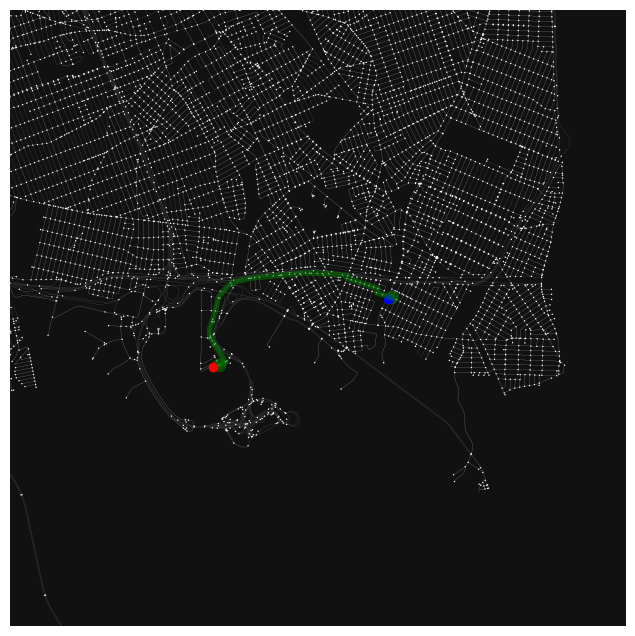

In [105]:
def plot_routes_for_random_addresses_in_2_zones(gdf:gpd.GeoDataFrame, zone1: int, zone2: int):
    gdf.geometry.to_crs(4326)
    zone1_bbox = gdf.loc[gdf['objectid'] == str(zone1)]['geometry'].item()
    g_z1 = ox.graph_from_polygon(zone1_bbox,network_type='drive',retain_all=True)
    g_z1 = ox.utils_graph.get_undirected(g_z1)
    random_address_z1 = ox.utils_geo.sample_points(g_z1,1).to_crs(4326)
    raz1_list = random_address_z1.to_list()
    raz1_lat = float((str(raz1_list).split(' '))[1].strip('('))
    raz1_lon = float((str(raz1_list).split(' '))[2].strip(')>]'))

    zone2_bbox = gdf.loc[gdf['objectid'] == str(zone2)]['geometry'].item()
    g_z2 = ox.graph_from_polygon(zone2_bbox)
    g_z2 = ox.utils_graph.get_undirected(g_z2)
    random_address_z2 = ox.utils_geo.sample_points(g_z2, 1).to_crs(4326)
    raz2_list = random_address_z2.to_list()
    raz2_lat = float((str(raz2_list).split(' '))[1].strip('('))
    raz2_lon = float((str(raz2_list).split(' '))[2].strip(')>]'))

    g = ox.graph_from_place('New York City, NY, USA', network_type = 'drive')
    random_node_z1 = ox.nearest_nodes(g,raz1_lat,raz1_lon)
    random_node_z2 = ox.nearest_nodes(g,raz2_lat,raz2_lon)
    route = ox.shortest_path(g, random_node_z1, random_node_z2, weight='length')

    G = nx.compose(g_z1, g_z2).to_undirected()
    c = ox.graph_to_gdfs(G, edges=False).unary_union.centroid
    bbox = ox.utils_geo.bbox_from_point(point=(c.y, c.x), dist=5000)

    fig, ax = ox.plot_graph_route(g, route, 'g', show=False, close=False, node_size=1, node_color='w', edge_color='w', edge_linewidth=0.05,bbox = bbox)

    random_address_z1.plot(color = 'r', ax = ax)
    random_address_z2.plot(color = 'b', ax = ax)
    return

plot_routes_for_random_addresses_in_2_zones(nyc_gdf, 132, 219)

In [109]:
street_closures = pd.read_csv('2018_street_closures.csv')
g = ox.graph_from_place('NYC, NY, USA', network_type='drive')
g_gdf = ox.graph_to_gdfs(g,nodes=False, edges=True, node_geometry=False, fill_edge_geometry=False)
nyc = g_gdf
nyc = nyc[~nyc['name'].apply(lambda x: isinstance(x, list))]

# create sample dataframe
# define function to remove suffix from street name
def remove_suffix(name):
    # check if value is a string
    if isinstance(name, str):
        # apply regular expression to remove suffix
        return re.sub(r'(?<=\d)(st|nd|rd|th)\b', '', name)
    # if value is not a string or is NaN, return NaN
    else:
        return np.nan

# apply function to 'name' column and overwrite existing values
nyc['name'] = nyc['name'].apply(remove_suffix)

/Users/tzacks2/.conda/envs/DataViz/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [111]:
nyc[['name','geometry']].dropna()

name  \
u           v          key                            
39076461    274283981  0       Cross Island Parkway   
39076490    277672005  0       Cross Island Parkway   
39076504    462122450  0       Cross Island Parkway   
42421728    42432736   0          Central Park West   
            42435337   0          Central Park West   
...                                             ...   
10840270527 42842442   0                  25 Avenue   
10840270528 42808526   0    Willets Point Boulevard   
10853807645 4616536348 0              Broome Street   
10858288590 42437678   0             West 34 Street   
            246650510  0                  12 Avenue   

                                                                     geometry  
u           v          key                                                     
39076461    274283981  0    LINESTRING (-73.79463 40.78641, -73.79309 40.7...  
39076490    277672005  0    LINESTRING (-73.75709 40.76243, -73.75741 40.7...  
39076504    462122450  0    LINESTRING (-73.74416 40.75347, -73.74552 40.7...  
42421728    42432736   0    LINESTRING (-73.96004 40.79805, -73.95996 40.7...  
            42435337   0    LINESTRING (-73.96004 40.79805, -73.96011 40.7...  
...                                                                       ...  
10840270527 42842442   0    LINESTRING (-73.81729 40.77633, -73.81721 40.7...  
10840270528 42808526   0    LINESTRING (-73.81729 40.77648, -73.81752 40.7...  
10853807645 4616536348 0    LINESTRING (-74.00692 40.72449, -74.00616 40.7...  
10858288590 42437678   0    LINESTRING (-74.00503 40.75707, -74.00491 40.7...  
            246650510  0    LINESTRING (-74.00503 40.75707, -74.00512 40.7...  

[91754 rows x 2 columns]

u           v           key
42423020    42434965    0      LINESTRING (-73.97497 40.74609, -73.97502 40.7...
42424089    42442961    0      LINESTRING (-73.96436 40.76062, -73.96440 40.7...
42429340    42443037    0      LINESTRING (-73.95174 40.77788, -73.95181 40.7...
42429693    42443000    0      LINESTRING (-73.95934 40.76750, -73.95938 40.7...
42429900    42442891    0      LINESTRING (-73.97953 40.73979, -73.97957 40.7...
                                                     ...                        
7925143983  3931534871  0      LINESTRING (-73.93434 40.80137, -73.93439 40.8...
8132470015  42496182    0      LINESTRING (-73.99439 40.67140, -73.99484 40.6...
            42496175    0      LINESTRING (-73.99439 40.67140, -73.99393 40.6...
9924890061  42496120    0                                                   None
            42496133    0      LINESTRING (-74.00644 40.65918, -74.00617 40.6...
Name: geometry, Length: 245, dtype: geometry


Text(0.5, 1.0, '2nd Avenue Outlined on Zone Map with Street View')

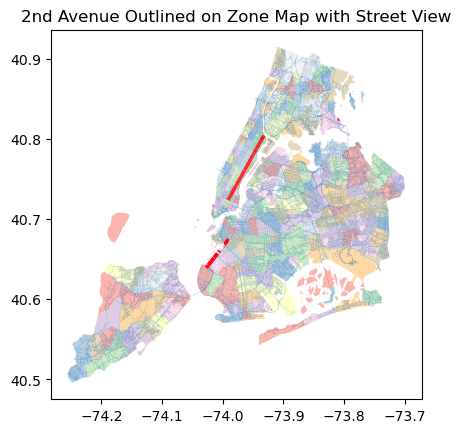

In [112]:
ax = nyc.geometry.plot(linewidth = 0.05)
nyc_gdf.plot(ax = ax,cmap = 'Pastel1',linewidth = .2)

sec_ave = nyc.loc[nyc['name'] == '2 Avenue'].geometry
print(sec_ave)
sec_ave.plot(color = 'r', ax = ax, linewidth = 2.5,linestyle = '--')
ax.set_title('2nd Avenue Outlined on Zone Map with Street View')